# Multilayer Perceptron (MLP)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

# Import jax eco-system
import jax
import jax.numpy as jnp

import flax.linen as nn
import optax

## 0. Train parameters

In [8]:
NUM_CLASSES = 10
BATCH_SIZE = 64

## 1. Prepare dataset

In [3]:
# Get train/test datasets and convert them into iterable batches
def get_datasets(num_epochs, batch_size):

    # Dataset classes
    classes = np.array([
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ])
    
    # downoad Cifar-10 dataset
    train_ds = tfds.load('cifar10', split='train')
    test_ds = tfds.load('cifar10', split='test')

    # Normalizing images and mapping them as tf tensor
    train_ds = train_ds.map(lambda sample: {'image': (tf.cast(sample['image'], tf.float32) / 255.),
                                            'label': sample['label']})
    
    test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                            'label': sample['label']})

    # Tensorflow dataloader
    train_ds = train_ds.repeat(num_epochs).shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return classes, train_ds, test_ds

checking datasets and labels. The images looks very blur because we've normalized them.

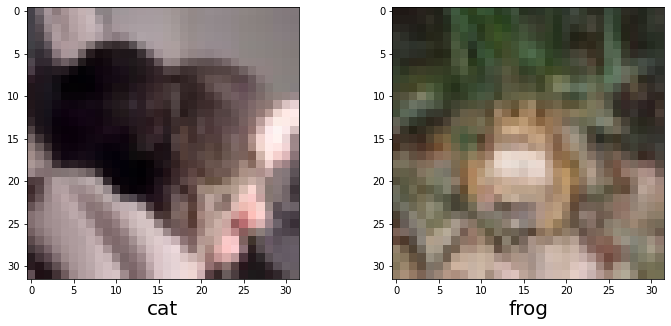

In [4]:
classes, train_ds, test_ds = get_datasets(10, 32)
check_train = next(iter(train_ds))
check_test = next(iter(test_ds))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(check_train['image'][0])
axes[0].set_xlabel(classes[check_train['label'][0].numpy()], fontsize=20)
axes[1].imshow(check_test['image'][0])
axes[1].set_xlabel(classes[check_test['label'][0].numpy()], fontsize=20)
plt.show()

In [5]:
print(check_train['image'].numpy().shape)

(32, 32, 32, 3)


## 2. Define the MLP network

In [6]:
class MLP(nn.Module):
    num_classes:int
    
    @nn.compact
    def __call__(self, x):
        x = x.reshape(x.shape[0], -1)
        x = nn.Dense(features=200)(x)
        x = nn.relu(x)
        x = nn.Dense(features=150)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)
        return x

In [7]:
mlp = MLP(NUM_CLASSES)
print(mlp.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 32, 32, 3)))) # shape: (batch, h, w, channel)


                                     MLP Summary                                      
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs             ┃ outputs        ┃ params                    ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[1,32,32,3] │ float32[]      │                           │
├─────────┼────────┼────────────────────┼────────────────┼───────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,3072]    │ float32[1,200] │ bias: float32[200]        │
│         │        │                    │                │ kernel: float32[3072,200] │
│         │        │                    │                │                           │
│         │        │                    │                │ 614,600 (2.5 MB)          │
├─────────┼────────┼────────────────────┼────────────────┼───────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,200]     │ 